# Spray Glider - Data Processing 

**Purpose**: Code for collocating bathymetry with Spray glider observations 

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook: 

In [1]:
%matplotlib inline


Import python libraries


In [4]:
#--- Build-in Python Functions ---# 
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from datetime import datetime, timedelta
import pandas as pd
import cartopy.crs as ccrs
import sys
import os
import matplotlib 
from geopy.distance import geodesic
import cftime
import matplotlib.dates as mdates
import gsw


# Set path to access python functions
sys.path.append('/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling/tools/')

#--- Luke's Python Functions ---# 
import cartopy_figs as cart

Load aviso, bathymetry and spray glider data 

In [5]:
# Set path to project directory
PATH = "/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling"

#--- Spray Glider Data ---# 
filename_sg = PATH + "/data/spray_gliders/CUGN_line_80.nc"
nc = Dataset(filename_sg, 'r')

# Extract data variables
profile = nc.variables['profile'][:]
depth   = nc.variables['depth'][:]

lon = nc.variables['lon'][:]
lat = nc.variables['lat'][:]
lon_uv = nc.variables['lon_uv'][:]
lat_uv = nc.variables['lat_uv'][:]
time =  num2date(nc.variables['time'][:], nc.variables['time'].units)
time_uv =  num2date(nc.variables['time_uv'][:], nc.variables['time_uv'].units)

temperature = nc.variables['temperature'][:]  # In-situ temperature (units: degrees celcius)
salinity = nc.variables['salinity'][:]  # Practical Salinity (units: unitless)

#--- Bathymetry ---# 
filename_b = PATH + "/data/bathymetry/topo_25.1.nc"
ds_bathy = xr.open_dataset(filename_b)

# Extract data variables
lon_b = ds_bathy["lon"]  
lat_b = ds_bathy["lat"]  
z     = ds_bathy["z"]    

#--- AVISO SLA ---#
filename_aviso = PATH + "/data/aviso/aviso_tot_nrt_ccs.nc"
nc = Dataset(filename_aviso, 'r')

# Extract data variables
lon_a  = np.array(nc.variables['lon'][:]) 
lat_a  = np.array(nc.variables['lat'][:])  
time_a =  np.array(nc.variables['time'][:]) # Matlab datetime: days since 1-Jan-0000   

ssh = np.array(nc.variables['SSH'][:])
sla = np.array(nc.variables['SLA'][:]) 

/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Convert matlab datetime to python datetime 

In [6]:
# MATLAB's day 1 is 1-Jan-0000, while NumPy's datetime starts from 1-Jan-0001. I need to adjust for this by subtracting 366 days
days_offset = 366
time_a_ndt = np.datetime64('0001-01-01') + np.timedelta64(1, 'D') * (time_a - days_offset)

# Convert the NumPy datetime array into Python datetime objects
time_a_pdt = np.array([pd.Timestamp(d).to_pydatetime() for d in time_a_ndt])

Convert cftime.DatetimeGregorian to Python datetime objects

In [7]:
time_dt = np.ma.array(
    [datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) if not np.ma.is_masked(d) else np.ma.masked for d in time], 
    mask=[np.ma.is_masked(d) for d in time]  
)
time_dt_uv = np.ma.array(
    [datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) if not np.ma.is_masked(d) else np.ma.masked for d in time_uv], 
    mask=[np.ma.is_masked(d) for d in time_uv]  
)

Extract bathymetry data within the region of the spray wave glider

In [8]:
# Set the latitude and longitude limits
lon_lim = [-124, -119]
lat_lim = [32.50, 35]

# Extract data 
lat_r = lat_b[(lat_b >= lat_lim[0]) & (lat_b <= lat_lim[1])]
lon_r = lon_b[(lon_b >= lon_lim[0]) & (lon_b <= lon_lim[1])]
z_r = z[(lat_b >= lat_lim[0]) & (lat_b <= lat_lim[1]), (lon_b >= lon_lim[0]) & (lon_b <= lon_lim[1])] 

For each spray glider profile, assign a water depth value

In [9]:
# Set the number of profiles
nprofile = len(profile)

# Initailize an array for water depth
water_depth = np.ma.zeros([nprofile,])
water_depth_uv = np.ma.zeros([nprofile,])

# Loop through each of the along track data points
for idata in range(nprofile):

    # Check if latitude or longitude is masked
    if not np.ma.is_masked(lat[idata]) and not np.ma.is_masked(lat[idata]):

        # Find the indices of the closest longitude and latitude grid point in the bathymetry grid to the trajectory of the spray glider
        idx_lat = np.abs(lat_r - lat[idata]).argmin()
        idx_lon = np.abs(lon_r - lon[idata]).argmin()
        idx_lat_uv = np.abs(lat_r - lat_uv[idata]).argmin()
        idx_lon_uv = np.abs(lon_r - lon_uv[idata]).argmin()

        # Assign the water depth to the ith profile
        water_depth[idata] = z_r[idx_lat,idx_lon]
        water_depth_uv[idata] = z_r[idx_lat_uv,idx_lon_uv]

    else:
        
        # Assign a masked value to the water depth to the ith profile if lon and/or latitude is a masked value
        water_depth[idata] = np.ma.masked
        water_depth_uv[idata] = np.ma.masked
        

Grab Glider trajectory data from the years where we have AVISO data and compute daily averages 

In [10]:
# Convert time series to datetime and filter out masked time steps from time, lat, and lon
time_dt_nm = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time if not np.ma.is_masked(d)])
lat_nm = np.array([l for l in lat if not np.ma.is_masked(l)])
lon_nm = np.array([l for l in lon if not np.ma.is_masked(l)])

# Find the indices of overlap between Glider and AVISO data 
time_a_i, time_a_f = time_a_pdt[1], time_a_pdt[-1]
idx_time = (time_dt_nm >= time_a_i) & (time_dt_nm <= time_a_f)

# Grad time, latitude, and longitude 
time_s = time_dt_nm[idx_time] 
lat_s = lat_nm[idx_time]
lon_s = lon_nm[idx_time]

# Extract unique dates (ignoring hours, minutes, and seconds)
dates = np.array([dt.date() for dt in time_s]) 
unique_dates = np.unique(dates) 
time_d = np.array([datetime.combine(d, datetime.min.time()) for d in unique_dates]) 

# Compute daily averages 
lon_d = np.array([lon_s[dates == d].mean() for d in unique_dates])
lat_d = np.array([lat_s[dates == d].mean() for d in unique_dates])

For each daily averaged spray glider trajctory data, assign a SSH and SLA value

**Note**: The SSH and SLA aviso data is on a daily time interval, so assigning a SSH and SLA properly to the trajectory of the glider requires us to obtain daily averaged spray glider data

In [11]:
# Set the number of daily data points in the spray glider data 
ndays = len(time_d) 

# Initailize an array for SSH and SLA
ssh_d = np.ma.zeros([ndays,])
sla_d = np.ma.zeros([ndays,])

# Loop through each of the along track daily spray glider data points
for idata in range(ndays):

    # Check if latitude or longitude is masked
    if not np.ma.is_masked(lat_d[idata]) and not np.ma.is_masked(lat_d[idata]) and not np.ma.is_masked(time_d[idata]):

        # Find the indices of the closest longitude and latitude grid point in the bathymetry grid to the trajectory of the spray glider
        idx_lat = np.abs(lat_a - lat_d[idata]).argmin()
        idx_lon = np.abs(lon_a - lon_d[idata]).argmin()
        idx_time = np.abs(time_a_pdt - time_d[idata]).argmin()

        # Assign the water depth to the ith profile
        ssh_d[idata] = ssh[idx_lon,idx_lat,idx_time]
        sla_d[idata] = sla[idx_lon,idx_lat,idx_time]

    else:
        
        # Assign a masked value to the water depth to the ith profile if lon and/or latitude is a masked value
        ssh_d[idata] = np.ma.masked
        sla_d[idata] = np.ma.masked

Compute the distance from shore at the daily time interval

In [12]:
# Set the latitude and longutiude coordinates of point conception
lon_pc = -120.457673
lat_pc = 34.4488552
point_pc = (lat_pc,lon_pc)
point_sb = (34.23,-121.3)

# Initialize masked array
distance_d = np.ma.zeros([ndays,])

# Loop through time steps 
for idata in range(0,ndays):

    #--- Sea State Variables ---# 

    # Check if latitude or longitude is masked
    if not np.ma.is_masked(lat_d[idata]) and not np.ma.is_masked(lon_d[idata]):

        # Generate coordinate pair 
        point_g = (lat_d[idata],lon_d[idata])

        # Compute the distance from the shore relative to Point Conception 
        distance_d[idata] = geodesic(point_g, point_pc).kilometers

    else:
    
        # Assign a masked value to the water depth to the ith profile if lon and/or latitude is a masked value
        distance_d[idata] = np.ma.masked

# Compute the distance from the shore relative to Point Conception 
distance_sb = geodesic(point_sb, point_pc).kilometers

Compute distance from shore using point conception as a reference point

In [13]:
# Set the latitude and longutiude coordinates of point conception
lon_pc = -120.457673
lat_pc = 34.4488552
point_pc = (lat_pc,lon_pc)
point_sb = (34.23,-121.3)

# Initialize masked array
distance = np.ma.zeros([nprofile,])
distance_uv = np.ma.zeros([nprofile,])

# Loop through time steps 
for idata in range(0,nprofile):

    #--- Sea State Variables ---# 

    # Check if latitude or longitude is masked
    if not np.ma.is_masked(lat[idata]) and not np.ma.is_masked(lon[idata]):

        # Generate coordinate pair 
        point_g = (lat[idata],lon[idata])

        # Compute the distance from the shore relative to Point Conception 
        distance[idata] = geodesic(point_g, point_pc).kilometers

    else:
    
        # Assign a masked value to the water depth to the ith profile if lon and/or latitude is a masked value
        distance[idata] = np.ma.masked

    #--- Current Velocity Variables ---# 

    # Check if latitude or longitude is masked
    if not np.ma.is_masked(lat_uv[idata]) and not np.ma.is_masked(lon_uv[idata]):

        # Generate coordinate pair 
        point_g_uv = (lat_uv[idata],lon_uv[idata])

        # Compute the distance from the shore relative to Point Conception 
        distance_uv[idata] = geodesic(point_g_uv, point_pc).kilometers

    else:
    
        # Assign a masked value to the water depth to the ith profile if lon and/or latitude is a masked value
        distance_uv[idata] = np.ma.masked

# Compute the distance from the shore relative to Point Conception 
distance_sb = geodesic(point_sb, point_pc).kilometers

Compute pressure, Conservative temperature, absolute salinity, and in-situ/potenital density from temperature, practical salinity, and depth

In [14]:
# Convert depths to the coordinate system with positive z up 
depth_conv = -1 * depth  # Units: m

# Initialize an array for the pressure, conservative temperature, absolute salinity, and in-situ/potential density 
pressure = np.zeros_like(temperature)
CT       = np.zeros_like(temperature)
SA       = np.zeros_like(temperature)
density  = np.zeros_like(temperature)
sigma0   = np.zeros_like(temperature)

# Loop through profile time steps 
for idata in range(0,nprofile):

    # Compute pressure from depth and latitude
    pressure[:,idata] = gsw.conversions.p_from_z(depth_conv,lat[idata])  # Units: dbar

    # Compute absolute salinity 
    SA[:,idata] = gsw.conversions.SA_from_SP(salinity[:,idata], pressure[:,idata], lon[idata], lat[idata]) # Units: g/kg

    # Compute Conservative temperature from absolute salinity, in-situ temperature and pressure
    CT[:,idata] = gsw.conversions.CT_from_t(SA[:,idata], temperature[:,idata], pressure[:,idata])  # Units: degrees Celcius

    # Compute in-situ and potential density (with reference pressure of 0 dbar) 
    density[:,idata] = gsw.density.rho(SA[:,idata],CT[:,idata],pressure[:,idata])  # Units: kg/m^3
    sigma0[:,idata] = gsw.density.sigma0(SA[:,idata], CT[:,idata])  # Units: kg/m^3

Compute the squared buoyancy frequency using Emery et al. (1984) formation: 

$$
N^2(z_{k +1/2}) = - \frac{g}{\rho_o} \bigg[\frac{\rho_{\theta}(z_k) - \rho_{\theta}(z_{k + 1})}{ z_k - z_{k+1}} \bigg]
$$

where $z_{k+1/2} \equiv (z_k + z_{k + 1})/2$ is the midpoint between standard depths $z_k$ and $z_{k+1}$ with positive upward convention for depth $z_k > z_{k+1}$, $g = 9.81 m/s^{-2}$ is the gravitational accerelation constant, $\rho_{o}$ is the average potential density in the top 100 meters throughout the time record, and $\rho_\theta$ is potential density.

The Emery approach has a systematically low bias due to the thermobaric effect: the increase in compressiblity of sea water with decreasing temperature. The Chelton et al. 1998 formulation: 

$$
N^2(z_{k +1/2}) = - \frac{g}{\rho_o} \bigg[\frac{\rho(z_k \rightarrow z_{k+1/2}) - \rho(z_{k+1} \rightarrow z_{k+1/2})}{z_k - z_{k+1}} \bigg]
$$

In [15]:
# Set physical parameters 
g = 9.81  # Units: m/s^2
rho_theta = sigma0 + 1000
rho0 = np.ma.mean(rho_theta[(depth >= depth[0]) & (depth <= 500),:])
depth_conv = -1*depth
N_depth = len(depth)

#--- Potential Density Method ---# 

# Compute the midpoints of the depth bins 
depth_mid_pdm = (depth[:-1] + depth[1:]) / 2

# Initialize an array for bouyancy frequency
Nsquare_pdm = np.zeros((N_depth-1,nprofile))

# Loop through time steps
for idata in range(0,nprofile):

    # Compute N^2 profiles 
    Nsquare_pdm[:,idata] = (-g/rho0) * (np.diff(rho_theta[:,idata]) / np.diff(depth_conv)) 

# Compute bouyancy frequency in units of cycles/hr
Nz_pdm = np.sqrt(Nsquare_pdm) * (60/1) * (60/1) 


#--- Neutral Density Gradient Method ---# 

# Initalize arrays 
depth_mid_ndgm = np.zeros((N_depth-1))
Nsquare_ndgm = np.zeros((N_depth-1,nprofile))

# Loop through time steps
for idata in range(0,nprofile):

    # Loop through depth pairs 
    for k in range(0,len(depth_conv)-1):

        # Compute the midpoint standard depth 
        z_half = (depth_conv[k] + depth_conv[k+1]) / 2

        # Convert standard depth to a reference pressure 
        p_half = gsw.conversions.z_from_p(z_half,lat[idata])

        # Compute the potential density referenced to p_half pressure
        sigma_ref_top  = gsw.pot_rho_t_exact(SA[k,idata], temperature[k,idata], pressure[k,idata], p_half)
        sigma_ref_bottom  = gsw.pot_rho_t_exact(SA[k+1,idata], temperature[k+1,idata], pressure[k+1,idata], p_half)

        # Compute N^2(z) profile 
        Nsquare_ndgm[k,idata] = (-g/rho0) * ((sigma_ref_top - sigma_ref_bottom)/(depth_conv[k] - depth_conv[k+1]))

        # Save the midpoints of the depth bins 
        if idata == 0:
            depth_mid_ndgm[k] = z_half

# Compute bouyancy frequency in units of cycles/sec
Nz_ndgm = np.sqrt(Nsquare_ndgm) * (60/1) * (60/1) 

/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_27080/1680929165.py:23: RuntimeWarning: invalid value encountered in sqrt
  Nz_pdm = np.sqrt(Nsquare_pdm) * (60/1) * (60/1)
/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_27080/1680929165.py:49: UserWarning: Warning: converting a masked element to nan.
  Nsquare_ndgm[k,idata] = (-g/rho0) * ((sigma_ref_top - sigma_ref_bottom)/(depth_conv[k] - depth_conv[k+1]))
/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_27080/1680929165.py:56: RuntimeWarning: invalid value encountered in sqrt
  Nz_ndgm = np.sqrt(Nsquare_ndgm)


Remove masked time steps from time, CT, SA, and Density 

In [38]:
# Set counter 
cn = 0

# Find the number of unmasked elements in the time coordinate and the length of the depth coordinate
N_depth = len(depth)
N_profiles = np.sum(~time_dt.mask)

# Initialize new arrays for CT, SA and density 
time_dt_n = []
CT_n      = np.zeros((N_depth,N_profiles))
SA_n      = np.zeros((N_depth,N_profiles))
density_n = np.zeros((N_depth,N_profiles))
sigma0_n = np.zeros((N_depth,N_profiles))
Nsquare_pdm_n = np.zeros((N_depth-1,N_profiles))
Nz_pdm_n = np.zeros((N_depth-1,N_profiles))
Nsquare_ndgm_n = np.zeros((N_depth-1,N_profiles))
Nz_ndgm_n = np.zeros((N_depth-1,N_profiles))

# Loop through time steps
for idata in range(0,nprofile):

    # Check if time step is masked 
    if not np.ma.is_masked(time_dt[idata]):

        # Save time, CT, SA, and denisty in new arrays
        time_dt_n.append(time_dt[idata])
        CT_n[:,cn]      = CT[:,idata]
        SA_n[:,cn]      = SA[:,idata]
        density_n[:,cn] = density[:,idata]
        sigma0_n[:,cn]  = sigma0[:,idata]
        Nsquare_pdm_n[:,cn] = Nsquare_pdm[:,idata]
        Nz_pdm_n[:,cn]      = Nz_pdm[:,idata]
        Nsquare_ndgm_n[:,cn] = Nsquare_ndgm[:,idata]
        Nz_ndgm_n[:,cn]      = Nz_ndgm[:,idata]

        # Reintialize counter 
        cn += 1

# Convert time list into an array 
time_dt_n = np.array(time_dt_n)

# Compute density anomaly 
density_anom_n = density_n - 1000

Plot the output of the gsw toolbox

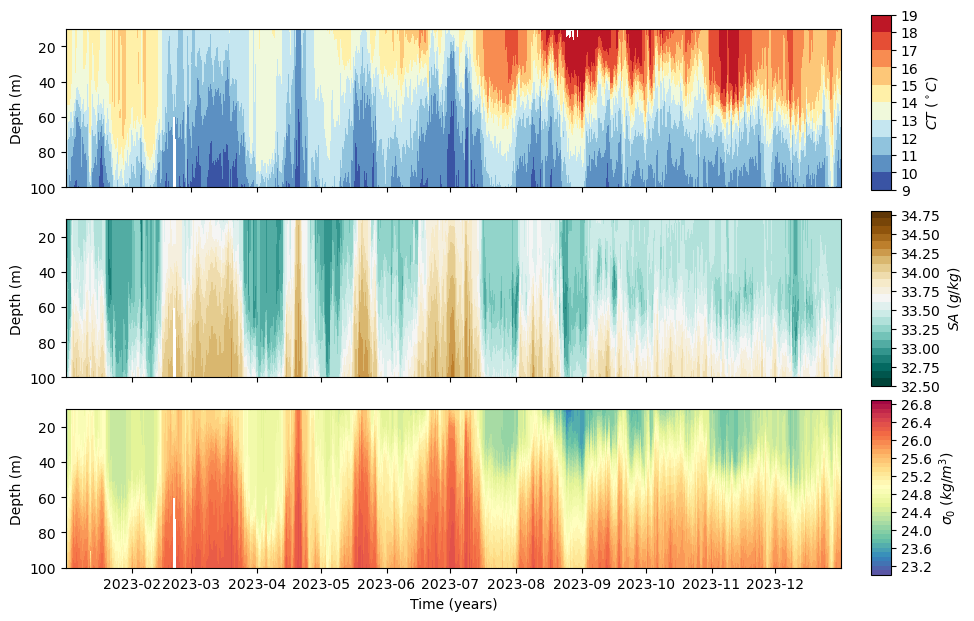

In [20]:
# Find depth bins to plot 
depth_bin = 100
time_i, time_f = datetime(2023,1,1,0,0,0), datetime(2023,12,31,23,59,59)
idx_depth = (depth >= depth[0]) & (depth <= depth_bin)
idx_depth_mid = (depth_mid_pdm >= depth[0]) & (depth_mid_pdm <= depth_bin)
idx_time = (time_dt_n >= time_i) & (time_dt_n <= time_f)

# Set plotting parameters
levels_temp = np.arange(9,20,1)
levels_sal  = np.arange(32.5,34.9,0.1)
levels_sig  = np.arange(23,27,0.1) 
fontsize = 10

# Create a figure with subplots
fig, axes = plt.subplots(3,1)

# Set the figure size using set_size_inches
fig.set_size_inches(10, 7) 

#--- Conservative Temperature ---# 
c1 = axes[0].contourf(time_dt_n[idx_time],depth[idx_depth],CT_n[np.ix_(idx_depth,idx_time)],cmap='RdYlBu_r',levels=levels_temp)

# Set axis attributes
axes[0].set_xlabel("")
axes[0].set_ylabel("Depth (m)")
axes[0].invert_yaxis()
axes[0].set_xticklabels([]) 

# Create colormbar
cax = plt.axes([0.93, 0.65, 0.02, 0.25])
cart.set_cbar(
    c1,
    cax,
    fig,
    orientation="vertical",
    extend="both",
    cbar_label=r"$CT$ ($^\circ C$)",
    nbins=10,
    fontsize=fontsize,
    cbar_ticks=[],
    task="regular",
)

#--- Absolute Salinity ---# 
c2 = axes[1].contourf(time_dt_n[idx_time],depth[idx_depth],SA_n[np.ix_(idx_depth,idx_time)],cmap='BrBG_r',levels=levels_sal)

# Set axis attributes
axes[1].set_xlabel("")
axes[1].set_ylabel("Depth (m)")
axes[1].invert_yaxis()
axes[1].set_xticklabels([]) 

# Create colormbar
cax = plt.axes([0.93, 0.37, 0.02, 0.25])
cart.set_cbar(
    c2,
    cax,
    fig,
    orientation="vertical",
    extend="both",
    cbar_label=r"$SA$ ($g/kg$)",
    nbins=10,
    fontsize=fontsize,
    cbar_ticks=[],
    task="regular",
)

#--- Potential Density ---# 
c3 = axes[2].contourf(time_dt_n[idx_time],depth[idx_depth],sigma0_n[np.ix_(idx_depth,idx_time)],cmap='Spectral_r',levels=levels_sig)

# Set axis attributes
axes[2].set_xlabel("Time (years)")
axes[2].set_ylabel("Depth (m)")
axes[2].invert_yaxis()

# Create colormbar
cax = plt.axes([0.93, 0.1, 0.02, 0.25])
cart.set_cbar(
    c3,
    cax,
    fig,
    orientation="vertical",
    extend="both",
    cbar_label=r"$\sigma_0$ ($kg/m^{3}$)",
    nbins=10,
    fontsize=fontsize,
    cbar_ticks=[],
    task="regular",
)

# Display figure
plt.show()

# Save figure
fig.savefig(fname = PATH + '/figs/spray_glider/overview_line80/CT_SA_rho_profiles', bbox_inches = 'tight', dpi=300)


Plot the bouyancy frequency 

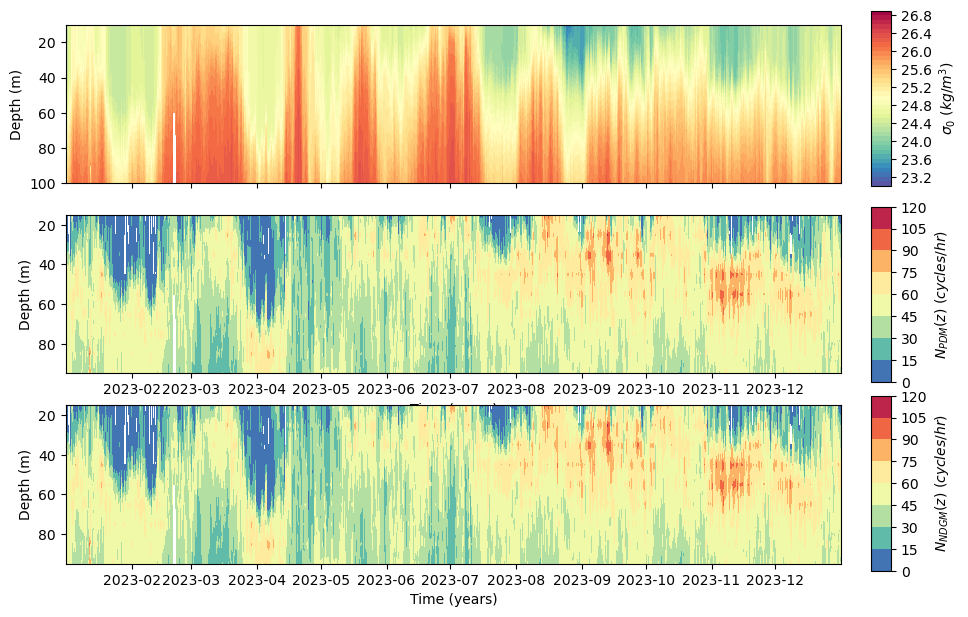

In [39]:
# Find depth bins to plot 
depth_bin = 100
idx_depth_mid_pdm = (depth_mid_pdm >= depth[0]) & (depth_mid_pdm <= depth_bin)
idx_depth_mid_ndgm = (depth_mid_ndgm <= depth_conv[0]) & (depth_mid_ndgm >= -1*depth_bin)

# Set plotting parameters
levels_N = np.arange(9,20,1)
levels_sig  = np.arange(23,27,0.1) 
fontsize = 10

# Create a figure with subplots
fig, axes = plt.subplots(3,1)

# Set the figure size using set_size_inches
fig.set_size_inches(10, 7) 

#--- Potential Density ---# 
c1 = axes[0].contourf(time_dt_n[idx_time],depth[idx_depth],sigma0_n[np.ix_(idx_depth,idx_time)],cmap='Spectral_r',levels=levels_sig)

# Set axis attributes
axes[0].set_xlabel("")
axes[0].set_ylabel("Depth (m)")
axes[0].invert_yaxis()
axes[0].set_xticklabels([]) 

# Create colormbar
cax = plt.axes([0.93, 0.65, 0.02, 0.25])
cart.set_cbar(
    c1,
    cax,
    fig,
    orientation="vertical",
    extend="both",
    cbar_label=r"$\sigma_0$ ($kg/m^{3}$)",
    nbins=10,
    fontsize=fontsize,
    cbar_ticks=[],
    task="regular",
)

#--- PDM Bouyancy Frequency ---# 
c2 = axes[1].contourf(time_dt_n[idx_time],depth_mid_pdm[idx_depth_mid_pdm],Nz_pdm_n[np.ix_(idx_depth_mid_pdm,idx_time)],cmap='Spectral_r')

# Set axis attributes
axes[1].set_xlabel("Time (years)")
axes[1].set_ylabel("Depth (m)")
axes[1].invert_yaxis()

# Create colormbar
cax = plt.axes([0.93, 0.37, 0.02, 0.25])
cart.set_cbar(
    c2,
    cax,
    fig,
    orientation="vertical",
    extend="both",
    cbar_label=r"$N_{PDM}(z)$ ($cycles/hr$)",
    nbins=10,
    fontsize=fontsize,
    cbar_ticks=[],
    task="regular",
)

#--- PDM Bouyancy Frequency ---# 
c3 = axes[2].contourf(time_dt_n[idx_time],-1*depth_mid_ndgm[idx_depth_mid_ndgm],Nz_ndgm_n[np.ix_(idx_depth_mid_ndgm,idx_time)],cmap='Spectral_r')

# Set axis attributes
axes[2].set_xlabel("Time (years)")
axes[2].set_ylabel("Depth (m)")
axes[2].invert_yaxis()

# Create colormbar
cax = plt.axes([0.93, 0.1, 0.02, 0.25])
cart.set_cbar(
    c3,
    cax,
    fig,
    orientation="vertical",
    extend="both",
    cbar_label=r"$N_{NDGM}(z)$ ($cycles/hr$)",
    nbins=10,
    fontsize=fontsize,
    cbar_ticks=[],
    task="regular",
)

# Display figure
plt.show()

# Save figure
fig.savefig(fname = PATH + '/figs/spray_glider/overview_line80/rho_N_profiles', bbox_inches = 'tight', dpi=300)

Save intermediate data in a netCDF for future use

In [42]:
# Save variables in data arrays

#--- Sea State Varibles ---# 
Pressure = xr.DataArray(data=pressure, 
                    dims=['depth','profile',],
                    coords=dict(depth=depth,profile=profile),
                    attrs=dict(
                        description='Pressure profiles.',
                        units='dbar'
                        )
)

Density = xr.DataArray(data=density, 
                    dims=['depth','profile',],
                    coords=dict(depth=depth,profile=profile),
                    attrs=dict(
                        description='In-situ Density profiles.',
                        units='kg/m^3'
                        )
) 

SIG = xr.DataArray(data=sigma0, 
                    dims=['depth','profile',],
                    coords=dict(depth=depth,profile=profile),
                    attrs=dict(
                        description='Potential Density anomaly profiles referenced to the pressure at the sea surface.',
                        units='kg/m^3'
                        )
) 

CTemp = xr.DataArray(data=CT, 
                    dims=['depth','profile',],
                    coords=dict(depth=depth,profile=profile),
                    attrs=dict(
                        description='Conservative temperature profiles.',
                        units='degrees Celcius'
                        )
) 

ASal = xr.DataArray(data=SA, 
                    dims=['depth','profile',],
                    coords=dict(depth=depth,profile=profile),
                    attrs=dict(
                        description='Absolute Salinity profiles.',
                        units='g/kg'
                        )
) 

N2_pdm = xr.DataArray(data=Nsquare_pdm, 
                    dims=['depth_mid','profile',],
                    coords=dict(depth_mid=depth_mid_pdm,profile=profile),
                    attrs=dict(
                        description='Bouyance Frequency profiles computed using the Emery et al. (1984) formulation.',
                        units='(cycles/second)^2'
                        )
)

N2_ndgm = xr.DataArray(data=Nsquare_ndgm, 
                    dims=['depth_mid','profile',],
                    coords=dict(depth_mid=-1*depth_mid_ndgm,profile=profile),
                    attrs=dict(
                        description='Bouyance Frequency profiles computed using the Chelton et al. (1998) formulation.',
                        units='(cycles/second)^2'
                        )
)


#--- Distance from shore ---# 
DIST = xr.DataArray(data=distance, 
                    dims=['profile'],
                    coords=dict(profile=profile),
                    attrs=dict(
                        description='Distance of spray glider profile from shore relative to point conception: (-120.457673, 34.4488552).',
                        units='km'
                        )
)
DIST_uv = xr.DataArray(data=distance_uv, 
                       dims=['profile'],
                       coords=dict(profile=profile),
                       attrs=dict(
                           description='Distance of spray glider profile from shore relative to point conception: (-120.457673, 34.4488552) for horizontal velocity measurements.',
                           units='km'
                    )
)
DIST_aviso = xr.DataArray(data=distance_d, 
                       dims=['time_d'],
                       coords=dict(time_d=time_d),
                       attrs=dict(
                           description='Distance of spray glider profile from shore relative to point conception: (-120.457673, 34.4488552) for AVISO SSH and SLA measurements.',
                           units='km'
                    )
)

#--- Water Depth ---# 
WATER_DEPTH = xr.DataArray(data=water_depth,
                           dims=['profile'],
                           coords=dict(profile=profile),
                           attrs=dict(
                               description='Depth of water which the spray glider performed its profile. Water depth of profile is obtained by finding the closest grid point in the ETOPO2 bathymetry map to the position of the spray glider.',
                               units='m'
                           )
)
WATER_DEPTH_uv = xr.DataArray(data=water_depth_uv,
                              dims=['profile'],
                              coords=dict(profile=profile),
                              attrs=dict(
                                  description='Depth of water which the spray glider performed its profile for horizontal velocity measurements. Water depth of profile is obtained by finding the closest grid point in the ETOPO2 bathymetry map to the position of the spray glider.',
                                  units='m'
                           )
)

#--- AVISO SSH and SLA ---# 
SSH = xr.DataArray(data=ssh_d,
                           dims=['time_d'],
                           coords=dict(time_d=time_d),
                           attrs=dict(
                               description='Sea Surface Height (SSH) along the trajectory of the spray glider from the AVISO satellite product. AVISO SSH product is mapped onto the trajectory of the glider by finding the closest grid point in the SSH map to the position of the spray glider. Spray Glider trajectory is daily averaged to match the time steps of the AVISO product.',
                               units='m'
                           )
)
SLA = xr.DataArray(data=sla_d,
                              dims=['time_d'],
                              coords=dict(time_d=time_d),
                              attrs=dict(
                                  description='Sea Level Anomaly (SLA) along the trajectory of the spray glider from the AVISO satellite product. AVISO SLA product is mapped onto the trajectory of the glider by finding the closest grid point in the SLA map to the position of the spray glider. Spray Glider trajectory is daily averaged to match the time steps of the AVISO product.',
                                  units='m'
                           )
)

#--- Time in datetime units ---# 
TIME = xr.DataArray(data=time_dt, 
                    dims=['profile'],
                    coords=dict(profile=profile),
                    attrs=dict(
                        description='Time steps of spray glider profile.'
                        )
) 

TIME_uv = xr.DataArray(data=time_dt_uv, 
                       dims=['profile'],
                       coords=dict(profile=profile),
                       attrs=dict(
                           description='Time steps of spray glider profile for horizontal velocity measurements.'
                           )
) 

# Create a data set from data arrays 
data = xr.Dataset({'Pressure':Pressure,'Density':Density,'SIG':SIG,'CTemp':CTemp,'ASal':ASal,'N2_pdm':N2_pdm,'N2_ndgm':N2_ndgm,'DIST':DIST,'DIST_uv':DIST_uv,'DIST_aviso':DIST_aviso,'WATER_DEPTH':WATER_DEPTH, 'WATER_DEPTH_uv':WATER_DEPTH, 'SSH':SSH,'SLA':SLA,'TIME':TIME,'TIME_uv':TIME_uv})

# Check if file exists, then delete it
file_path = PATH + "/data/spray_gliders/CUGN_line_80_intermediate_data.nc"
if os.path.exists(file_path):
    os.remove(file_path)

# Create netcdf file
data.to_netcdf(file_path,mode='w')